# ⚙ Data preperation

## Load libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import random

## Load training dataset

In [2]:
df = pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')

## Inspect the last 55 avaliable time IDs

In [3]:
time = df['time_id'].unique()
print(time[-55:])

[1165 1166 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178
 1179 1180 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192
 1193 1194 1195 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206
 1207 1208 1209 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219]


## Drop a portion of time IDs

In [4]:
df.drop(df[df['time_id'] < 1190].index,inplace = True)

time = df['time_id'].unique()
print(len(time))

df.head()

30


,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
3039038,1190_0,1190,0,-0.275204,-0.699480,1.753958,-1.149581,0.501886,0.378265,1.014885,...,1.077533,1.591306,1.733118,0.109469,2.995621,0.206071,-0.099151,-2.406765,-0.658959,0.542424
3039039,1190_1,1190,1,-2.122237,0.129197,1.405702,0.217612,-0.219672,-0.150986,0.002175,...,0.614218,0.199014,0.486399,0.708371,1.123878,-0.457443,-0.257334,-0.979053,-2.088422,-0.313193
3039040,1190_2,1190,2,0.068803,1.563168,0.801341,-0.649677,-0.160695,-0.185313,0.099784,...,-1.128734,0.585466,-1.463381,-0.561141,0.545990,-0.326550,0.585217,0.197166,-1.353786,-0.311518
3039041,1190_3,1190,3,-0.005059,-0.032720,-0.694698,-1.669162,0.864283,0.194807,-2.077522,...,-0.791586,-1.524765,0.062602,-0.098907,-1.078261,0.628101,-3.682928,-1.947962,-0.787047,2.245104
3039042,1190_4,1190,4,1.316753,0.736624,-0.462361,-1.065353,-0.588141,0.196450,1.198063,...,-0.165893,0.415816,0.612639,-0.331669,1.208506,0.601037,0.539700,0.594945,-1.746073,0.057862


## Compute the mean and standard deviation of each feature

Store in metadata dataframe and save to zip file to be used later

In [5]:
metadata = pd.DataFrame(columns=['mean', 'std'],index=range(300))

for index in range(300):
    metadata['mean'][index] = df['f_'+str(index)].mean()
    metadata['std'][index] = df['f_'+str(index)].std()
metadata.head()

,mean,std
0,-0.001332,1.111438
1,-0.011045,1.060394
2,0.008783,1.044003
3,-0.020013,0.993583
4,0.001098,1.047791


In [6]:
metadata.to_parquet('./metadata', compression='gzip')

## Load dataframe containing information about clustering of investments

In [7]:
df_clusters = pd.read_parquet('../input/2-clusters/2_cluster.parquet')
df_clusters.head()

,investment_id,cluster_id
0,0,1.0
1,1,2.0
2,2,1.0
3,3,2.0
4,4,1.0


## Determine the number of clusters and select a cluster to perform datapreperation on
Clusters are numbered 1, 2, 3... which cluster 0 corresponding to any inverstment IDs whcih have not been placed in cluster

In [8]:
num_clusters = len(df_clusters['cluster_id'].unique())-1
current_cluster = 2

# Create a training, validation and test set for the chosen cluster

## Create list of investment IDs to be placed in training, validation and test

In [9]:
investment_list = []
for i in range(len(df_clusters)):
    if df_clusters.cluster_id[i] == current_cluster:
        investment_list.append(df_clusters.investment_id[i])

print('number of investments =', len(investment_list))

inv_train = investment_list[0:len(investment_list)*7//10]
inv_valid = investment_list[len(investment_list)*7//10:len(investment_list)*9//10]
inv_test  = investment_list[len(investment_list)*9//10:]

print('sanity check:',len(inv_train)+len(inv_valid)+len(inv_test))
print(len(inv_train)/len(investment_list),len(inv_valid)/len(investment_list),len(inv_test)/len(investment_list))

number of investments = 1605
sanity check: 1605
0.6996884735202492 0.2 0.10031152647975078


## Create a training, validation and test dataframe

In [10]:
df_train  = df[df['investment_id'].isin(list(inv_train))]

df_test  = df[df['investment_id'].isin(list(inv_test))]

df_valid  = df[df['investment_id'].isin(list(inv_valid))]


In [11]:
print('number of investments =', len(investment_list))
print('sanity check:',len(df_train['investment_id'].unique())+len(df_valid['investment_id'].unique())+len(df_test['investment_id'].unique()))

number of investments = 1605
sanity check: 1605


## Renormalises all features 
This ensures that all feature values are on the same scale.

In [12]:
for index in range(300):
    df_train[['f_'+str(index)]] = df_train[['f_'+str(index)]].subtract(metadata['mean'][index])
    df_valid[['f_'+str(index)]] = df_valid[['f_'+str(index)]].subtract(metadata['mean'][index])
    df_test[['f_'+str(index)]]  = df_test[['f_'+str(index)] ].subtract(metadata['mean'][index])
    
    df_train[['f_'+str(index)]] = df_train[['f_'+str(index)]]/ (metadata['std'][index] + 1e-12)
    df_valid[['f_'+str(index)]] = df_valid[['f_'+str(index)]]/ (metadata['std'][index] + 1e-12)
    df_test[['f_'+str(index)]]  = df_test[['f_'+str(index)]] / (metadata['std'][index] + 1e-12)
    

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


## Sort by investment followed by time ID

In [13]:
df_train = df_train.sort_values(by=['investment_id','time_id'])
df_test = df_test.sort_values(by=['investment_id','time_id'])
df_valid = df_valid.sort_values(by=['investment_id','time_id'])

In [14]:
df_train.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
3039039,1190_1,1190,1,-2.122237,0.117441,1.336057,0.200028,-0.200948,-0.145147,-0.002968,...,0.539658,0.170628,0.449091,0.635751,0.947428,-0.450420,-0.215100,-0.855532,-1.929326,-0.299557
3042372,1191_1,1191,1,0.092467,0.304520,0.609152,0.857534,-0.808235,-0.163414,0.862686,...,0.514438,0.545874,3.543956,0.826021,1.163362,-0.473317,-1.023344,-0.898323,-1.619835,-0.255787
3045737,1192_1,1192,1,0.151874,1.015338,-0.086064,0.772946,-1.024464,-0.170060,0.809992,...,0.429429,0.939174,1.896151,-0.419295,0.726514,-0.328875,-1.003616,0.789994,-0.555073,-0.252515
3049127,1193_1,1193,1,-0.030535,1.221100,-0.113554,0.801877,-0.771375,-0.154667,0.898420,...,0.204661,1.627842,-0.622924,0.001814,-1.291100,-0.698850,0.028365,0.799687,-0.774808,-0.419649
3052517,1194_1,1194,1,0.437932,1.564061,-0.219084,0.784532,-0.957565,-0.145679,0.346137,...,-0.030007,0.860971,-0.614518,-1.040945,1.300449,-0.531210,-0.321624,0.289998,-0.814158,-0.401237


## Interpolate missing data

Bellow the process is illustrated for the target values in the training dataset 

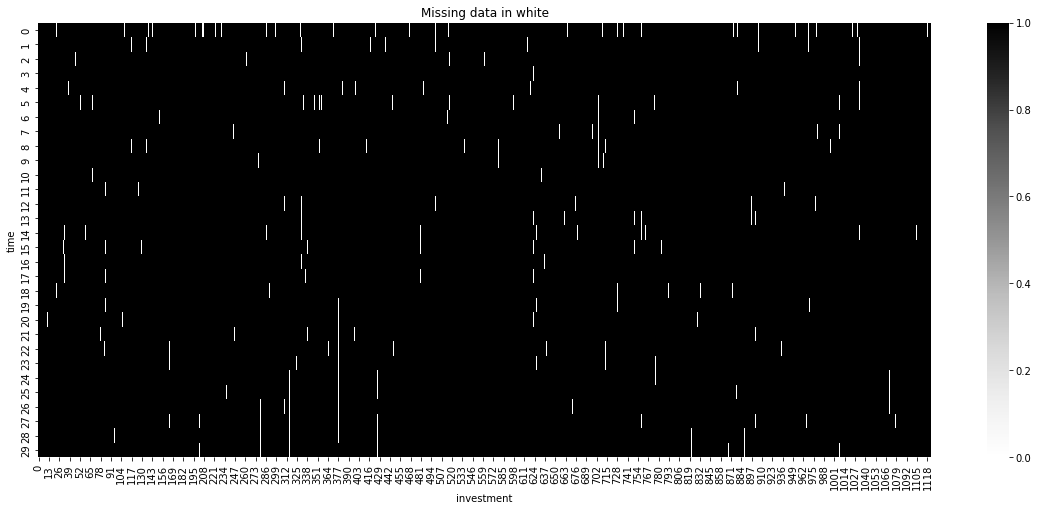

In [15]:
df_new = df_train[['investment_id','time_id','target']].pivot(index='time_id', columns ='investment_id', values='target')

plt.figure(figsize=(20,8))

ax = sns.heatmap(1-np.isnan(df_new.to_numpy()), cmap="Greys")

plt.title('Missing data in white')
plt.xlabel('investment')
plt.ylabel('time')

plt.show()

Fill forwards then backwards

In [16]:

df_new = df_new.fillna(method="ffill")
df_new = df_new.fillna(method="bfill")

df_new.head()

df_train_filled = df_new.melt(var_name='investment_id', value_name='target', ignore_index=False)


In [17]:
print(len(df_train_filled),len(df_train['investment_id'].unique())*len(df_train['time_id'].unique()))
df_train_filled.reset_index(inplace=True)
df_train_filled.head()

33690 33690


,time_id,investment_id,target
0,1190,1,-2.122237
1,1191,1,0.092467
2,1192,1,0.151874
3,1193,1,-0.030535
4,1194,1,0.437932


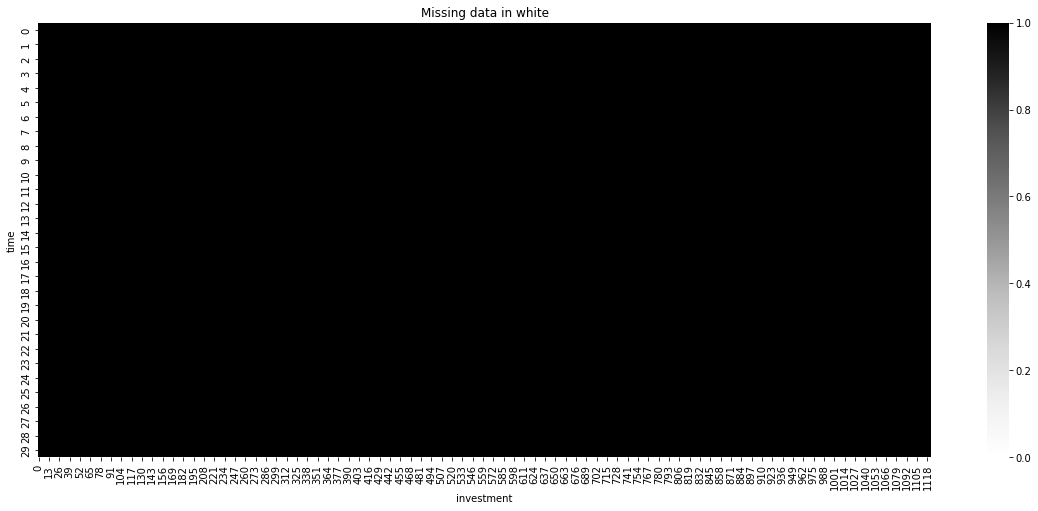

In [18]:
plt.figure(figsize=(20,8))

ax = sns.heatmap(1-np.isnan(df_new.to_numpy()), cmap="Greys",vmax=1,vmin=0)

plt.title('Missing data in white')
plt.xlabel('investment')
plt.ylabel('time')

plt.show()

## Repeat process for all features in the training dataset

In [19]:
for index in range(300):
    df_new = df_train[['investment_id','time_id','f_'+str(index)]].pivot(index='time_id', columns ='investment_id', values='f_'+str(index))
    df_new = df_new.fillna(method="ffill")
    df_new = df_new.fillna(method="bfill")
    df_new = df_new.melt(var_name='investment_id', value_name='f_'+str(index), ignore_index=False)
    df_train_filled['f_'+str(index+1)] = df_new['f_'+str(index)].to_numpy()
    


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [20]:
print('added values to train =',len(df_train_filled)-len(df_train))
df_train_filled.head()

added values to train = 250


,time_id,investment_id,target,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,f_300
0,1190,1,-2.122237,0.117441,1.336057,0.200028,-0.200948,-0.145147,-0.002968,-0.565976,...,0.539658,0.170628,0.449091,0.635751,0.947428,-0.450420,-0.215100,-0.855532,-1.929326,-0.299557
1,1191,1,0.092467,0.304520,0.609152,0.857534,-0.808235,-0.163414,0.862686,-0.825024,...,0.514438,0.545874,3.543956,0.826021,1.163362,-0.473317,-1.023344,-0.898323,-1.619835,-0.255787
2,1192,1,0.151874,1.015338,-0.086064,0.772946,-1.024464,-0.170060,0.809992,-1.356128,...,0.429429,0.939174,1.896151,-0.419295,0.726514,-0.328875,-1.003616,0.789994,-0.555073,-0.252515
3,1193,1,-0.030535,1.221100,-0.113554,0.801877,-0.771375,-0.154667,0.898420,-1.635045,...,0.204661,1.627842,-0.622924,0.001814,-1.291100,-0.698850,0.028365,0.799687,-0.774808,-0.419649
4,1194,1,0.437932,1.564061,-0.219084,0.784532,-0.957565,-0.145679,0.346137,-1.619898,...,-0.030007,0.860971,-0.614518,-1.040945,1.300449,-0.531210,-0.321624,0.289998,-0.814158,-0.401237


## Repeat process for validation and test datasets

In [21]:
df_new = df_valid[['investment_id','time_id','target']].pivot(index='time_id', columns ='investment_id', values='target')
df_new = df_new.fillna(method="ffill")
df_new = df_new.fillna(method="bfill")
df_valid_filled = df_new.melt(var_name='investment_id', value_name='target', ignore_index=False)

for index in range(300):
    df_new = df_valid[['investment_id','time_id','f_'+str(index)]].pivot(index='time_id', columns ='investment_id', values='f_'+str(index))
    df_new = df_new.fillna(method="ffill")
    df_new = df_new.fillna(method="bfill")
    df_new = df_new.melt(var_name='investment_id', value_name='f_'+str(index), ignore_index=False)
    df_valid_filled['f_'+str(index+1)] = df_new['f_'+str(index)].to_numpy()

df_valid_filled.reset_index(inplace=True)
print('added values to valid =',len(df_valid_filled)-len(df_valid))
df_valid_filled.head()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()


added values to valid = 104


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]


,time_id,investment_id,target,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,f_300
0,1190,2609,-0.061201,-0.250191,0.438600,2.149338,-0.617520,-0.255728,0.989015,0.115423,...,0.033643,1.668848,-0.286765,0.768971,-1.184680,-0.441723,-0.012717,0.724201,-1.733112,-0.704176
1,1191,2609,-0.233961,0.128837,0.551035,1.811031,-0.519209,-0.244495,0.593240,0.190066,...,1.186348,-0.499792,-0.411322,0.193252,0.750338,-0.452898,0.199212,1.359347,-1.651579,-0.694205
2,1192,2609,-0.126998,-0.444131,0.719668,1.446179,-0.625508,-0.261238,0.510019,-0.164592,...,0.990424,-0.877157,-0.412786,0.063723,-0.014877,-0.528433,0.339858,0.279232,-2.404763,-0.699318
3,1193,2609,0.293016,-0.496340,0.537548,1.511310,-0.818842,-0.262109,0.524515,-0.896779,...,1.071020,0.090647,-0.210568,0.355880,-0.044630,-0.839359,1.382041,-0.424744,-2.367198,-0.667029
4,1194,2609,0.091412,-0.041837,0.198583,1.987522,-0.817936,-0.246873,0.067983,-0.980695,...,0.217475,-0.133492,-0.371584,0.209467,-0.504454,-0.560683,-0.730263,-0.083911,-2.005372,-0.577171


In [22]:
df_new = df_test[['investment_id','time_id','target']].pivot(index='time_id', columns ='investment_id', values='target')
df_new = df_new.fillna(method="ffill")
df_new = df_new.fillna(method="bfill")
df_test_filled = df_new.melt(var_name='investment_id', value_name='target', ignore_index=False)

for index in range(300):
    df_new = df_test[['investment_id','time_id','f_'+str(index)]].pivot(index='time_id', columns ='investment_id', values='f_'+str(index))
    df_new = df_new.fillna(method="ffill")
    df_new = df_new.fillna(method="bfill")
    df_new = df_new.melt(var_name='investment_id', value_name='f_'+str(index), ignore_index=False)
    df_test_filled['f_'+str(index+1)] = df_new['f_'+str(index)].to_numpy()

df_test_filled.reset_index(inplace=True)
print('added values test =',len(df_test_filled)-len(df_test))
df_test_filled.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()


added values test = 41


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]


,time_id,investment_id,target,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,f_300
0,1190,3343,3.695418,0.891747,-0.618417,-1.314487,1.658175,-0.145222,-1.738492,0.519411,...,-2.321443,0.778009,-0.898460,0.729221,1.612538,8.506311,0.975039,1.944114,1.495665,-0.635142
1,1191,3343,-0.073458,1.164243,-0.088778,-1.476345,2.270411,-0.141770,-1.059745,0.005408,...,-2.688553,0.898878,0.036904,0.692805,0.179273,-0.017941,0.155361,1.111060,1.521391,-0.471366
2,1192,3343,-0.419417,1.213604,-0.116452,-2.010394,3.115935,-0.122198,-1.106612,-0.752239,...,-3.434932,1.143214,0.248022,0.359416,1.096542,-0.346462,1.223445,3.019190,1.608677,-0.440536
3,1193,3343,-0.034382,0.910897,0.271901,-1.848828,2.657564,-0.105062,-1.153733,-0.714587,...,-2.465214,0.218715,-0.195761,0.445945,3.330734,1.041750,-1.763295,2.136342,1.539820,-0.376783
4,1194,3343,-0.733093,0.453003,1.015306,-1.737455,3.215686,-0.119953,-1.714151,0.050244,...,-2.293862,-0.585587,1.455345,0.016785,-0.969209,-0.302271,-1.535171,1.109911,1.570687,-0.471614


## Create a separate "y" dataframe for target values and drop them from train, valid and test

In [23]:
y_train = df_train_filled[['time_id','investment_id','target']]
df_train_filled = df_train_filled.drop(['target'],axis = 1)

y_test = df_test_filled[['time_id','investment_id','target']]
df_test_filled = df_test_filled.drop(['target'],axis = 1)

y_valid = df_valid_filled[['time_id','investment_id','target']]
df_valid_filled = df_valid_filled.drop(['target'],axis = 1)

## Save training, validation and test dataframes and their corresponding target (y) dataframes

In [24]:
import os
os.mkdir('./Data')

In [25]:
y_train.to_parquet('./Data/y_train.parquet', compression='gzip')
y_test.to_parquet('./Data/y_test.parquet', compression='gzip')
y_valid.to_parquet('./Data/y_valid.parquet', compression='gzip')
df_train_filled.to_parquet('./Data/X_train.parquet', compression='gzip')
df_test_filled.to_parquet('./Data/X_test.parquet', compression='gzip')
df_valid_filled.to_parquet('./Data/X_valid.parquet', compression='gzip')

In [26]:
import shutil
shutil.make_archive('ubiquant_filled_v1_cluster_'+str(current_cluster)+'of'+str(num_clusters), 'zip', './Data')

'/kaggle/working/ubiquant_filled_v1_cluster_2of2.zip'